# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 5.6MB/s 
     |████████████████████████████████| 3.0MB 23.8MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
     |████████████████████████████████| 1.1MB 51.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5c1776d8601ce778a0a6a7e9da324a40c917cceb39c24687d7a26e5f3dbe0383
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Wed Jan 10 11:04:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [12]:
from datasets import load_dataset

dataset = load_dataset("izumi-lab/open-text-books")

Generating train split:   0%|          | 0/149700 [00:00<?, ? examples/s]

In [13]:
from datasets import load_dataset

dataset = pd.DataFrame(load_dataset("izumi-lab/open-text-books"))

array_of_books = []
for a in dataset['train']:
    array_of_books.append(a['text'])

df = pd.DataFrame(array_of_books,columns=['text'])
print(df)

                                                     text
0       ©2019 Rice University. Textbook content produc...
1       Trademarks\nThe OpenStax name, OpenStax logo, ...
2       OpenStax provides free, peer-reviewed, openly ...
3       OpenStax, OpenStax CNX, and OpenStax Tutor are...
4       Welcome to Chemistry 2e, an OpenStax resource....
...                                                   ...
149695  The first African-American to win a Nobel Priz...
149696  Sylvia Plath, 1961 Wikimedia Commons Public Do...
149697  Wikimedia Commons CC0 / Public Domain\nEver si...
149698  A Supermarket in California.” Collected Poems,...
149699  feminist\nThe advocacy of equality between the...

[149700 rows x 1 columns]


In [14]:
df.dropna(inplace=True) #remove NA values
books = df[:1000].text.copy() #just use the first 1000 books in this example

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-15-c97af49dc7c2>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

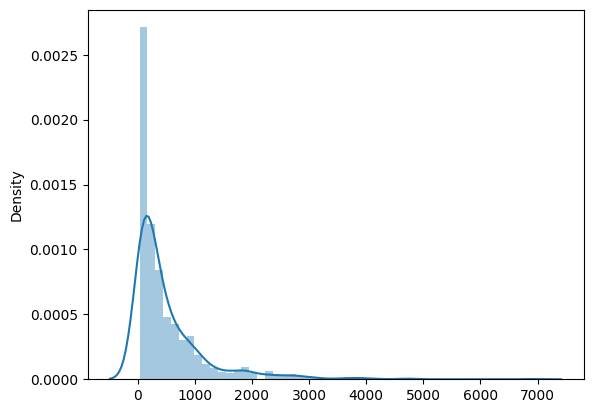

In [15]:
doc_lengths = []

for book in books:

    # get rough token count distribution
    tokens = nltk.word_tokenize(book)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [16]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.213

In [17]:
np.average(doc_lengths)

520.659

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [18]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [19]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [20]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [21]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [22]:
dataset = GPT2Dataset(books, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


In [23]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [24]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
#model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [25]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [28]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [29]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 2.179109573364258.   Elapsed: 0:00:48.
0:  bipartisan,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 1.7075600624084473.   Elapsed: 0:01:40.
0:  increasing

Using a hybrid strategy, which involves both the combustion of oxygen and the evaporation of water from solids, the concentration of CO2 will depend on the approximate relative concentration of the gases, or the approximate vapor pressure of the gases, to be reduced.

(d)

Solution. For liquid hydrogen, liquid oxygen, and methane, as well as for water, gas, and the earth, gas may be replaced by a hybrid formation.

(e)



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.7900291085243225.   Elapsed: 0:02:31.
0: dayThe ideal temperature of the elements in the water depends on the number of components that are present.
A solution of 18.15 L of 1.00 C. water is composed of 20.25 L of 1.00 Cl and 35.89 L of 1.00 O. The average temperature of the elements in the liquid in water is 0.022 °C.
As a general rule, equilibrium values for the concentrations of the two substances will correspond to those for water vapor. The concentrations of the elements will be equal. Therefore, equilibrium concentrations of the two substances will equalize when all the elements in the solution are present. In water vapor, the concentration of the element in the solution, regardless of which element is present, will not be equal. To obtain the maximum concentrations of the two substances, the solution must be made in a liquid with an elevated temperatures for boiling, but in the water vapor it will be completely liquid. This allows for an appropr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.6552780866622925.   Elapsed: 0:03:22.
0:  HangThis suggests that although certain nuclei contain relatively high energy and have higher valence valence density, those nuclei that contain relatively high energy and have lower valence density are more energetic when they form complexes, and those that have low energy and have higher valence density can not exhibit these paradoxical behaviors. This has been demonstrated by several studies involving low-energy nuclei, which result in paradoxical behaviors that result in paradoxical reactions with the nuclei exhibiting lower energy, increasing valence densities, or reacting with the structure.

  Average training loss: 2.55
  Training epoch took: 0:03:48

Running Validation...
  Validation Loss: 1.41
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.5485061407089233.   Elapsed: 0:00:49.
0:  foods of these products base of each is designated by its ionizable mass number (MSi) of 4.

FIGURE 10.16 Ionizes in a reaction are typically produced from pure iodine. Most of the reaction proceeds through the reactant chain by which the base ionizes. (credit: modification of work by “Nicole” Howard)
If the base ionization is made up of ionizable ions and bases of the same ionizable ion, then the formation of an ionizable base ionis not necessarily a result of a reaction involving the reaction of a few elements or molecules (e.g., amines) in the central or intermediate ion, respectively. However, as the activity of various ionizable bases decreases, the concentration of the ionized base ion decreases, so ionization is not an ideal process. In this example, the concentration of the ionizable base ion decreases from +3.5 to -1.9, and ionization is possible only


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 1.4479742050170898.   Elapsed: 0:01:40.
0:  trailThe molecular structure of the ionic compound is shown in. Most of the hydrogen atoms are composed of a single carbon atom and the molecules of the two carbon atoms possess only one carbon atom. This gives the compound a carbon, hydrogen, and a hydrogen atom that are essentially identical except for the molecular shape of the molecule. The four elements in the molecule act in similar ways and both of these elements must have different electron configurations. For example, the carbon atom is the central electron in the molecule and the hydrogen atom is the central atom. The chemical composition of these atoms is largely unknown because of their different chemical properties (see ).

FIGURE 11.21 The electron configuration of one of the atoms in the molecule changes due to its hybridization
By definition, the hybridization of the three elements is equivalent to the formation of a heterogeneous molecule (see 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.305658757686615.   Elapsed: 0:02:32.
0: intendin a flask containing oxygen, nitrogen, phosphorus, and other oxides that contain only hydrogen in the flask; the oxygen in a flask containing no oxygen in its constituent elements produces a gas with no oxygen atoms in the element. If the water in the flask, for example, is made into vinegar with a pH less than 1, this excess oxygen would cause the sulfur dioxide to dissolve. If the solution has a solution of equal volume, the excess sulfur dioxide will dissolve in water. Likewise, if the solution has equal volume, it will dissolve in aqueous water.
The volume of an alkaline solution is related to the volume occupied by the other elements. In a solution with a volume of 5.0 L, the water may occupy any volume within a volume of 5.0 L; if the solution has a volume of 9.0 L, the water may occupy any volume within an appropriate volume. In these solutions, the acidity will be equal to its pH (such as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.2002465724945068.   Elapsed: 0:03:23.
0:  surroundThis type of electrochemical reaction (also known as a chemical stoichiometry) occurs when electrochemical reactions that take place as part of a chemical reaction between reactants, products, and products (such as reduction reactions, desalination, or combustion reactions) take place as a reaction between two reactants. The chemical reaction can be spontaneous and does not involve an external source of energy. The same can be said for chemical reactions involving the formation of other substances, as it can be true for any chemical reaction. In general, this type of electrochemical reaction leads to the reduction of reactants in other substances, and a reaction between reactants, products, and products, as described previously. This is the basis for the concept of chemical equivalence. However, the concepts of chemical equivalence are not consistent with chemical stoichiometry. A similar situation exis

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.5131242275238037.   Elapsed: 0:00:49.
0:  reflexDetermination of Energy from Atomic Energy (Zinc, H2O3)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 1.478585958480835.   Elapsed: 0:01:38.
0:  displayCelsius
Solution
The ratio of the enthalpy changes in the constant C° for the enthalpy change of an equation is equal to 4.
Because the constant C° for an equation is greater than the constant c, a value of 24.4 °C is required for an equation that is constant at constant temperature. This equation is written for the enthalpy change of this equation:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.461424708366394.   Elapsed: 0:02:29.
0:  pastor
A living organism must have certain genetic mutations to survive as a living organism. Therefore, it must have a large variety of genes, along with its own variation in order to obtain the correct answer to a specific question. The mutation that results in the variation in variation in a genetic product is termed Mendelian disease.

The scientific name for Mendelian disease is the Mendel-Rutherford syndrome, a condition in which some individuals with a mutation in a gene that may affect a specific organism are subjected to the effects of certain poisons. It occurs in a variety of organisms that both are susceptible and thrive. Symptoms of this disease are vomiting, abdominal pain, joint stiffness, and tremors, and tremors can sometimes become worse after exposure to certain types of toxins. Symptoms of Mendelian disease are common in plants, insects, and protists that grow in colonies of their own species

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.8907548189163208.   Elapsed: 0:03:20.
0:  illicitCheck Your Learning
Determining a Determination of Reactivity in Aqueous and Liquid Potassium
Aqueous potassium chloride, NaCl2, has a mass of about 760 g/mol and a solubility of 1 mole per liter. Determine the molar amounts of sodium (Na+) and potassium (K+) in this amount of solution:
Determine the molar amounts of potassium (K+) and calcium (K+) in this amount of solution:

  Average training loss: 1.20
  Training epoch took: 0:03:46

Running Validation...
  Validation Loss: 1.31
  Validation took: 0:00:08

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.4876799583435059.   Elapsed: 0:00:49.
0:  Liberation(a)
(b)
(c)
(d)
(e)
(f )
(g)
(h)
(i)
(j)
(k)
(l)
(m)
(n)
(o)
(p)
(q)
(r)
(s)
(t )
(v)
(w)
(x)
(y)
(z)
(1)
(2)
(3)
(4)
(5)
(6)

(7)	
(8)
(9)	
(10)
(11)	
(12)
(13)
(14)
(15)
(16)
(17)
(18)	
(19)	
(20)
(21)
(22)
(23)	



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 1.3250367641448975.   Elapsed: 0:01:40.
0:  Nam. It is a compound with four carbon atoms and two hydrogen atoms. The principal quantum numbers of each carbon atom are listed below:
atomic number 3:	
hydrogen number 4:	
atomic number 5:	
carbon atom number 6:	
ionic number 7:	
isomers number 8, but we can rearrange these numbers ways:
identify the most common isomers in the carbon-hydrogen group of all atoms
form a Lewis structure showing the three principal quantum numbers of each carbon atom. Two of the carbon atoms form the π bond, with the hydrogen bonding to the octet's central atom. The remaining two will be the anionic isomers, and these are called the N groups in the listing. The central atom will be the second electron and so will be represented by the number 2d, followed by the π bond. We can also form bonds from these carbon atoms and hydrogen atoms.

Notice that there are more


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.419562816619873.   Elapsed: 0:02:31.
0: IONINTRODUCTION A living organism’s internal organs are organelles that contain internal organs that are controlled in a controlled manner using controlled chemical reactions. Organelles are controlled through the use of pharmaceutical drugs. The controlled production of pharmaceutical drugs is controlled by the control of the production processes used in these organisms through specific mechanisms of the cell—control of specific materials, control of specific environments, or in other words, control of “control of” a disease. Organelles are particularly important in controlling autoimmune diseases such as rheumatoid, lupus, and multiple organ failure.

FIGURE 18.21 The organelles in living cells are controlled in a controlled manner through specific chemical reactions. (credit a: modification of work by Cory Zanker; credit b: modification of work by Robert E. Howard)
The mainstance of control in living organisms

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.9317920207977295.   Elapsed: 0:03:22.
0:  glimpseThe energy absorbed or lost from a reaction is called the initial concentration (Q) of the reactant or product. This energy can be directly related to the concentration of one mole of product (M) or mole of reactant (Mp) as described in the preceding section on stoichiometric relationships. The energy of an atomic reaction depends on several factors: the temperature of the reactant or product, the molar amount of product or the number of moles of reactant involved. The reaction involves three processes: oxidation- reduction (ΔH), reduction- oxidation- reduction- oxidation- reduction- reduction- oxidation- reduction, and reduction- oxidation- reduction- reduction- oxidation.

  Average training loss: 1.08
  Training epoch took: 0:03:48

Running Validation...
  Validation Loss: 1.31
  Validation took: 0:00:08

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.634698748588562.   Elapsed: 0:00:49.
0:  LaureDetermining the Formal Formula for a Drug’s Electrolyte
Assuming that the ionic half-reaction product is the conjugate base of a given compound, how would the relative strengths of the two substances compare? Explain.
Solution
Write the equation for the relative strengths of the conjugate base conjugate acid-base pairs (or ions):
Write the formula for each of the conjugate base conjugate acid-base pair and its ionic half-reactions using the following information and a suitable relation:
Solution
Consider the conjugate base and its ions to be a mixture of reactant and product species. Writing the equation for each, predict the relative strengths of the conjugate base conjugate base pair and its ionic half-reactions using the following information and a suitable relation:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.46813690662384033.   Elapsed: 0:01:40.
0: ismThe equilibrium described so far contains one mole of water and two moles of ions (0.0210–2 mol H2O, the NaCl). This is the equilibrium constant for this reaction, shown on the right side of this equation:
The two mole amounts required to change the equilibrium constant from 0.0210–2 mol H2O to 100 mol H2O is given in.
Check Your Learning
The molar amounts of the following reactants and products are relevant in the analysis of Ksp, Ksp2, Osm:
 Ksp = 200 g NaCl (NaCl is solvated at 25 °C), Ksp2 = 200 g NH3 (NH3 is saturated at 25 °C), NH3 = 25 g Na2

Ksp = 200 g HNO2
Check Your Learning
What is the molar equivalence point for formation of CaCO3 from the following amounts of ionic compounds?
PO


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.522322416305542.   Elapsed: 0:02:31.
0: ounAn alkali metal is composed of an alkaline (magnesium), alkaline earth metal, or carbonate-containing element, with a sulfuric (sulfurous acid) and hydrohalic (hydrogen fluoride) character. An alkaline earth metal is particularly useful as a Lewis acid; its hydrohalic (hydrogen fluoride) character is that of a weak acid (hydrogen chloride) rather than that of a strong one.
An acidic earth metal is also useful as a Lewis acid because of the nonprescription of this compound in medicine, and it may treat conditions such as urinary infections, thyroid disease, and cancer.
The acid-base strength of an acidic earth metal range from 7 to 35+% with the exception of sulfuric acid being the strongest acid and containing the nonpolar anion. The strength of a nonpolar anion is approximately equal to that of a Lewis acid (a pH value less than 13; a stronger acid has a pH


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.4130037724971771.   Elapsed: 0:03:22.
0:  election(a) As long as there are two or more separate units of magnitude greater than 0, each unit of magnitude less than zero will count as one unit of positive value and both units of zero will give equal numbers of electrons. If more than two units of zero have the same atomic number and zero units of zero, the number of electrons in the system will equal two, the unit of zero (e.g., A = 8 and N = 9).
(b) For example, the three units of hydrogen in this equation have identical atomic numbers. Thus the formula for the triplets of hydrogen chloride and the one that we have just named is equal to:

  Average training loss: 0.98
  Training epoch took: 0:03:48

Running Validation...
  Validation Loss: 1.33
  Validation took: 0:00:08

Training complete!
Total training took 0:19:38 (h:mm:ss)


Let's view the summary of the training process.

In [31]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.55,1.41,0:03:48,0:00:08
2,1.37,1.34,0:03:49,0:00:08
3,1.20,1.31,0:03:46,0:00:08
4,1.08,1.31,0:03:48,0:00:08
5,0.98,1.33,0:03:48,0:00:08


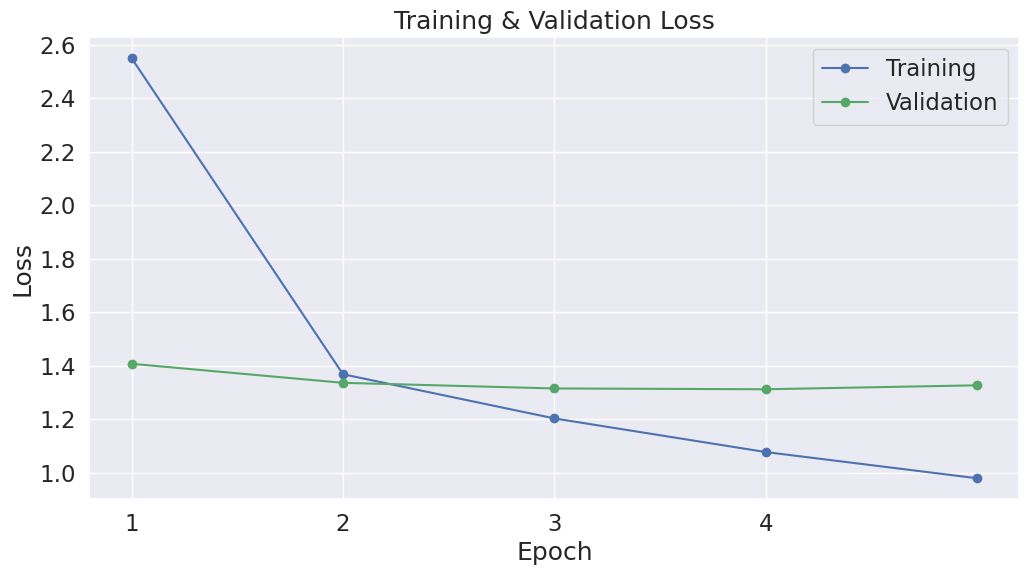

In [32]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [33]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [46]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Colab Notebooks/MLOps data'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/Colab Notebooks/MLOps data


('/content/drive/MyDrive/Colab Notebooks/MLOps data/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/MLOps data/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/MLOps data/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/MLOps data/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/MLOps data/added_tokens.json')

In [47]:
# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [45]:
model.eval()

prompt = "Remember, the mitochondria is the"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[16676,    11,   262, 25387,  7496,   318,   262]], device='cuda:0')
0: Remember, the mitochondria is the primary organelle used by cells to communicate with each other. mitochondria play an important role in storing energy, and they help maintain the cell’s balance and function. This particular cell function is responsible for malfunctioning genes that cause diseases such as cancer, heart disease, and other body problems.

REVIEW QUESTIONS
If an organism gains energy from a chemical reaction, it must obtain the required energy from ATP or FAD. How does ATP help?
By temporarily binding to NADPH or NAD+, the pathway allows the organism to switch between energy producing and generating chemical reactions. If a molecule cannot reach that energy level, ATP or FAD can stay in the cell. If, however, the concentration of a certain molecule increases, ATP or FAD can no longer enter the cell. Why is NADPH important, not just for energy production, but for glycolysis?
Energy is used to b

These aren't bad at all!
